In [3]:
# Download from https://github.com/facebookresearch/segment-anything
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from glob import glob
import h5py
from multiprocessing import Pool, cpu_count
import os
import cv2
import random

# (Done! No need to run) Predict with YOLO

In [7]:
def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data")
# From grey to RGB
all_frames = [np.stack([frame, frame, frame], axis=-1) for frame in all_frames]

In [5]:
model = YOLO("../DL_model/yolov8x-seg.pt")
results = model(all_frames, save = True)

/home/isaac/miniconda3/envs/cv_final/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0: 384x640 4 persons, 1 bicycle, 6 cars, 3 motorcycles, 1 bus, 5 traffic lights, 47.3ms
1: 384x640 4 persons, 7 cars, 4 motorcycles, 1 bus, 1 truck, 3 traffic lights, 47.3ms
2: 384x640 3 persons, 5 cars, 3 motorcycles, 1 bus, 8 traffic lights, 47.3ms
Speed: 1.5ms preprocess, 47.3ms inference, 216.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict2


In [ ]:
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
colors = [random.choices(range(256), k=3) for _ in classes_ids]

for result in tqdm(results): # 129 images
    if os.path.exists(f"../DL_masks/Yolo_masks_h5/{int(result.path.split('image')[-1].split('.')[0]):03d}.h5"):
        continue
    
    segmentations, areas, bboxs, point_coords, cls = [], [], [], [], []
    for mask, box in zip(result.masks.xy, result.boxes):
        
        points = np.int32([mask])
        label = np.full(all_frames[0].shape[0:2], np.nan)
        cv2.fillPoly(label, points, True)
        label = label == 1 # To bool
        
        segmentations.append(label)
        areas.append(label.sum())
        bboxs.append(box.xyxy.cpu().numpy().flatten().astype(int))
        
        # Centroid of points 
        point_coords.append(np.mean(mask, axis=0))
        cls.append(yolo_classes[classes_ids.index(int(box.cls[0]))])
    
    
    with h5py.File(f"../DL_masks/Yolo_masks_h5/{int(result.path.split('image')[-1].split('.')[0]):03d}.h5", 'w') as hf:
        hf.create_dataset('segmentations', data=np.array(segmentations), compression="gzip")
        hf.create_dataset('areas', data=np.array(areas), compression="gzip")
        hf.create_dataset('bboxs', data=np.array(bboxs), compression="gzip")
        hf.create_dataset('point_coords', data=np.array(point_coords), compression="gzip")
        hf.create_dataset('cls', data=cls)
        
    break
    

# Get object masks

In [3]:
def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data") ; print(np.array(all_frames).shape)
Yolo_h5_masks = sorted(glob('../DL_masks/Yolo_masks_h5/*.h5'))

(129, 2160, 3840)


In [4]:
# Open h5 mask
for idx, h5_mask in enumerate(Yolo_h5_masks):
    try:
        data = h5py.File(h5_mask, 'r')
        name = h5_mask.split('/')[-1].split('.')[0]
        segmentations = data['segmentations']
        # print(data.keys())
        # print(h5_mask, segmentations.shape)
    except Exception as e:
        print(e, h5_mask)
        continue

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'point_coords', 'segmentations']>
(20, 2160, 3840)


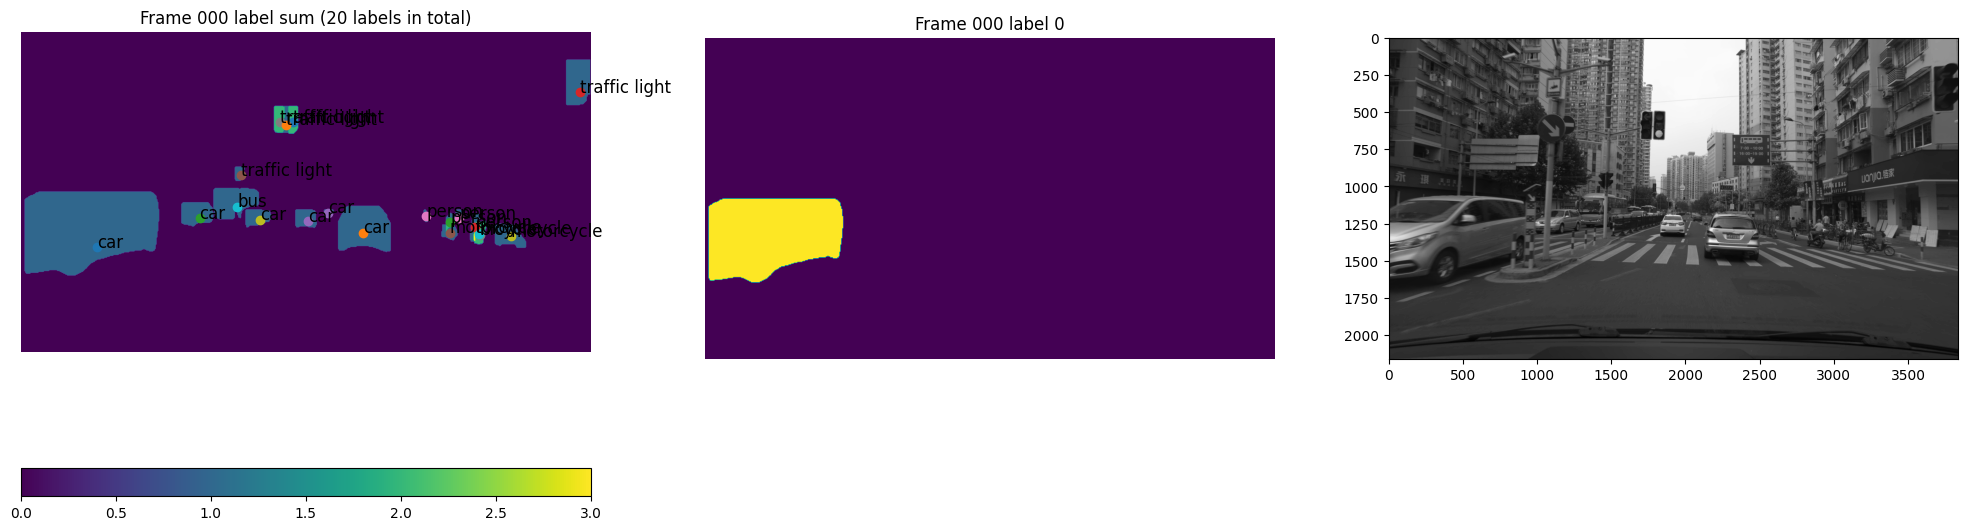

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'point_coords', 'segmentations']>
(20, 2160, 3840)


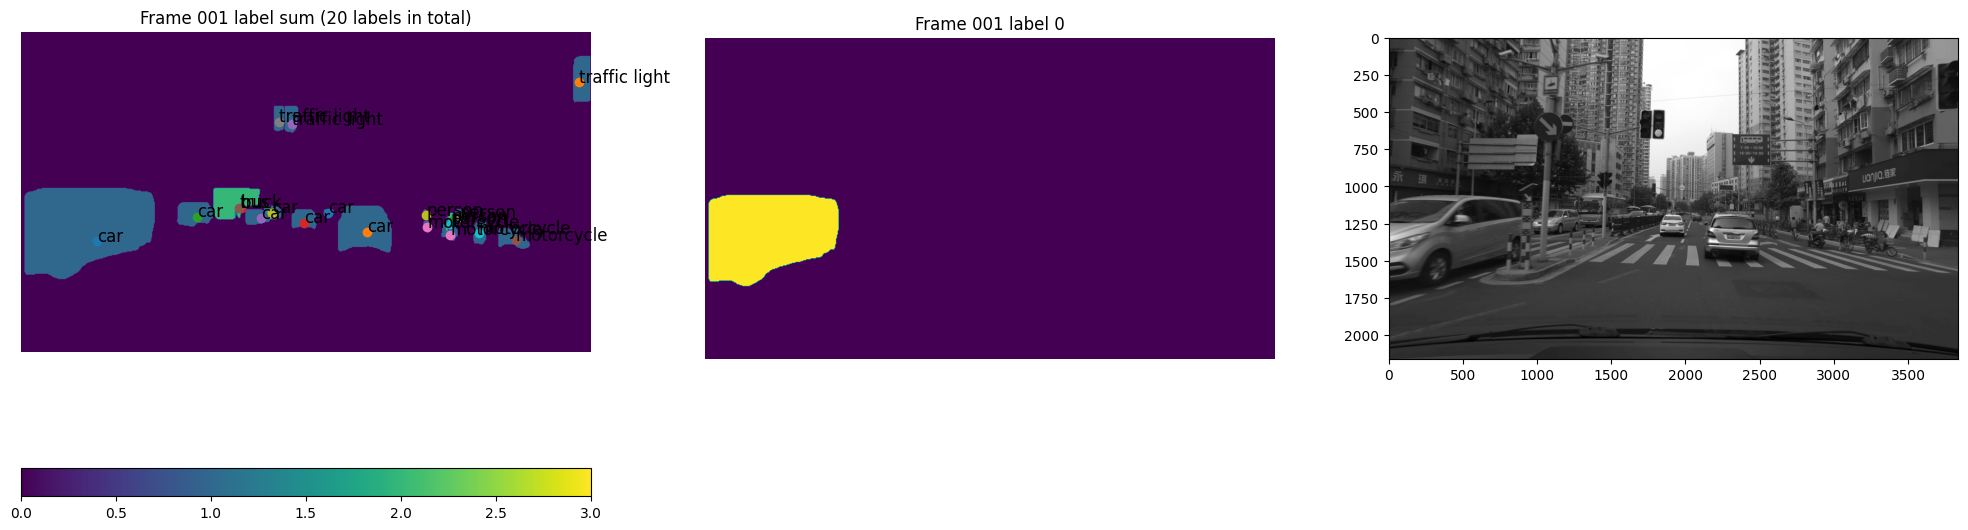

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'point_coords', 'segmentations']>
(20, 2160, 3840)


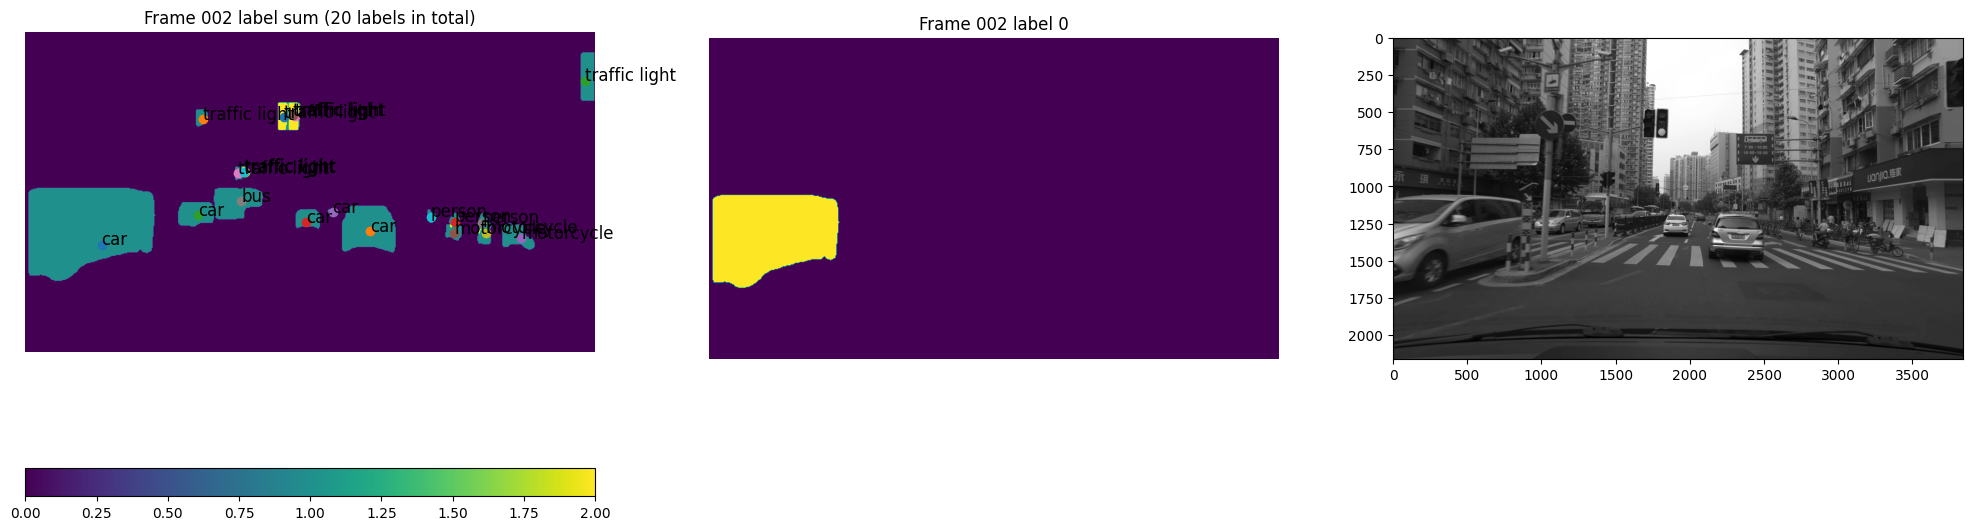

In [150]:
# Open h5 mask
for idx, h5_mask in enumerate(Yolo_h5_masks):
    data = h5py.File(h5_mask, 'r')
    name = h5_mask.split('/')[-1].split('.')[0]
    print(data.keys())
    segmentations = data['segmentations'][...]
    print(segmentations.shape)
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    im_l = ax[0].imshow(segmentations.sum(0))
    plt.colorbar(im_l, ax=ax[0], orientation='horizontal')
    
    point_coords = data["point_coords"]
    cls = data["cls"]
    
    for i, (point, cl) in enumerate(zip(point_coords, cls)):
        ax[0].scatter(point[0], point[1], label=cl)
        ax[0].text(point[0], point[1], cl.decode('UTF-8'), fontsize=12)
    
    ax[0].axis('off')
    ax[0].set_title(f"Frame {name} label sum ({segmentations.shape[0]} labels in total)")
    ax[1].imshow(segmentations[0])
    ax[1].axis('off')
    ax[1].set_title(f"Frame {name} label 0")
    ax[2].imshow(all_frames[idx], cmap='gray')
    
    plt.show()
    if idx == 2: break